In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skmultilearn.model_selection import iterative_train_test_split

2022-06-26 20:51:37.007334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
tf.__version__

'2.4.1'

# Data Load

In [4]:
df = pd.read_csv('/home/lab38/Multi_proj_6/data/straw_smallsizeimg_with_pest.csv')
df.head()

,image,grow,disease,area,points,original,disease-grow
0,/home/lab38/딸기/Strawberry Pest Damage_3.jpg,5,11,NaN,NaN,NaN,11-5
1,/home/lab38/딸기/Strawberry Pest Damage_727.jpg,2,11,NaN,NaN,NaN,11-2
2,/home/lab38/딸기/Strawberry Pest Damage_487.jpg,5,11,NaN,NaN,NaN,11-5
3,/home/lab38/딸기/Strawberry Pest Damage_124.jpg,5,11,NaN,NaN,NaN,11-5
4,/home/lab38/딸기/Strawberry Pest Damage_70.jpg,5,11,NaN,NaN,NaN,11-5


In [5]:
# label encoding
disease_encoder = LabelEncoder()
disease_encoder.fit(df['disease'])
df['disease'] = disease_encoder.transform(df['disease'])
print(df['disease'].unique())

grow_encoder = LabelEncoder()
grow_encoder.fit(df['grow'])
df['grow'] = grow_encoder.transform(df['grow'])
print(df['grow'].unique())

[3 0 1 2]
[4 1 3 0 2]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['image'],
                                                   df['disease-grow'],
                                                   stratify=df['disease-grow'],
                                                   test_size=0.2)

In [7]:
train_df = df[df['image'].isin(X_train)]
test_df = df[df['image'].isin(X_test)]

In [8]:
train_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20, # 최대 20도까지 회전
                            width_shift_range=0.1, # 최대 x 범위안에서 좌우/상하 이동
                            height_shift_range=0.1,
                            zoom_range=0.2, # 확대 축소 비율,
                            horizontal_flip=True, # 좌우반전
                            vertical_flip=True, # 상하반전
                            fill_mode='nearest')
valid_gen = ImageDataGenerator(rescale= 1. /255.)

# Model Top layer 학습

In [15]:
IMAGE_SIZE=320
BATCH_SIZE = 20
EPOCHS = 1000
DROPOUT = 0.2
LEARNING_RATE = 1e-3
ACTIVATION = 'elu'
OPTIMIZER = 'adam'
DENSE = 32

train_generator = train_gen.flow_from_dataframe(train_df, 
                                           x_col='image',
                                           y_col=['disease', 'grow'],
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           class_mode='multi_output',
                                           batch_size=BATCH_SIZE)
valid_generator = valid_gen.flow_from_dataframe(test_df,
                                           x_col='image',
                                           y_col=['disease','grow'],
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           class_mode='multi_output',
                                           batch_size=BATCH_SIZE)

MODEL_IMAGE_SIZE = 299
base_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)
base_model.trainable = False

# resizing model
input_data = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=x, name='resize')

# model
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT)(x)
backbone_out = layers.Dense(DENSE, activation=ACTIVATION)(x)

disease_outputs = layers.Dense(df['disease'].nunique(), activation='softmax',
                        name = 'diease_outputs')(backbone_out)
grow_outputs = layers.Dense(df['grow'].nunique(), activation='softmax',
                    name = 'grow_outputs')(backbone_out)

model = Model(inputs=inputs, 
              outputs=[disease_outputs, grow_outputs],
              name='strawberry')  

es = EarlyStopping(monitor='loss',
                   mode='auto',
                  patience=5,
                  verbose=1)

ckpt_path = './graph_toplayer.ckpt'
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_loss',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)

optimizer = Adam(learning_rate=LEARNING_RATE)

es = EarlyStopping(monitor='loss',
                   mode='auto',
                  patience=5,
                  verbose=1)

ckpt_path = './toplayer_strawberry.ckpt'
checkpointer = ModelCheckpoint(filepath=ckpt_path,
                              monitor='val_loss',
                              save_weights_only = True,
                              save_best_only= True,
                              verbose=1)

model.compile(loss={
              'diease_outputs' : 'sparse_categorical_crossentropy',
              'grow_outputs' : 'sparse_categorical_crossentropy'
              },
              optimizer=optimizer,
              metrics=['accuracy'])    

history = model.fit(train_generator,
                      validation_data=valid_generator,
                      verbose=1,
                      epochs=EPOCHS,
                      callbacks=[es, checkpointer],
                      steps_per_epoch=len(train_df)//BATCH_SIZE)

Found 13437 validated image filenames.
Found 3360 validated image filenames.
Epoch 1/1000
671/671 [==============================] - 316s 458ms/step - loss: 1.6887 - diease_outputs_loss: 0.7019 - grow_outputs_loss: 0.9868 - diease_outputs_accuracy: 0.7090 - grow_outputs_accuracy: 0.5858 - val_loss: 1.1825 - val_diease_outputs_loss: 0.4574 - val_grow_outputs_loss: 0.7251 - val_diease_outputs_accuracy: 0.8188 - val_grow_outputs_accuracy: 0.6905

Epoch 00001: val_loss improved from inf to 1.18247, saving model to ./toplayer_strawberry.ckpt
Epoch 2/1000
671/671 [==============================] - 306s 456ms/step - loss: 1.1584 - diease_outputs_loss: 0.4079 - grow_outputs_loss: 0.7505 - diease_outputs_accuracy: 0.8424 - grow_outputs_accuracy: 0.6749 - val_loss: 1.0273 - val_diease_outputs_loss: 0.3316 - val_grow_outputs_loss: 0.6957 - val_diease_outputs_accuracy: 0.8723 - val_grow_outputs_accuracy: 0.7125

Epoch 00002: val_loss improved from 1.18247 to 1.02732, saving model to ./toplayer_str


Epoch 00018: val_loss improved from 0.70083 to 0.69917, saving model to ./toplayer_strawberry.ckpt
Epoch 19/1000
671/671 [==============================] - 303s 452ms/step - loss: 0.7709 - diease_outputs_loss: 0.2276 - grow_outputs_loss: 0.5433 - diease_outputs_accuracy: 0.9147 - grow_outputs_accuracy: 0.7768 - val_loss: 0.6854 - val_diease_outputs_loss: 0.1748 - val_grow_outputs_loss: 0.5107 - val_diease_outputs_accuracy: 0.9354 - val_grow_outputs_accuracy: 0.7979

Epoch 00019: val_loss improved from 0.69917 to 0.68542, saving model to ./toplayer_strawberry.ckpt
Epoch 20/1000
671/671 [==============================] - 302s 450ms/step - loss: 0.7569 - diease_outputs_loss: 0.2210 - grow_outputs_loss: 0.5359 - diease_outputs_accuracy: 0.9163 - grow_outputs_accuracy: 0.7779 - val_loss: 0.6612 - val_diease_outputs_loss: 0.1722 - val_grow_outputs_loss: 0.4890 - val_diease_outputs_accuracy: 0.9384 - val_grow_outputs_accuracy: 0.8068

Epoch 00020: val_loss improved from 0.68542 to 0.66118, s


Epoch 00037: val_loss improved from 0.61678 to 0.60061, saving model to ./toplayer_strawberry.ckpt
Epoch 38/1000
671/671 [==============================] - 308s 459ms/step - loss: 0.7008 - diease_outputs_loss: 0.2021 - grow_outputs_loss: 0.4987 - diease_outputs_accuracy: 0.9239 - grow_outputs_accuracy: 0.7991 - val_loss: 0.6096 - val_diease_outputs_loss: 0.1582 - val_grow_outputs_loss: 0.4514 - val_diease_outputs_accuracy: 0.9464 - val_grow_outputs_accuracy: 0.8259

Epoch 00038: val_loss did not improve from 0.60061
Epoch 39/1000
671/671 [==============================] - 308s 459ms/step - loss: 0.7154 - diease_outputs_loss: 0.2013 - grow_outputs_loss: 0.5141 - diease_outputs_accuracy: 0.9221 - grow_outputs_accuracy: 0.7871 - val_loss: 0.5954 - val_diease_outputs_loss: 0.1454 - val_grow_outputs_loss: 0.4501 - val_diease_outputs_accuracy: 0.9479 - val_grow_outputs_accuracy: 0.8256

Epoch 00039: val_loss improved from 0.60061 to 0.59543, saving model to ./toplayer_strawberry.ckpt
Epoch 

671/671 [==============================] - 308s 459ms/step - loss: 0.6710 - diease_outputs_loss: 0.1828 - grow_outputs_loss: 0.4882 - diease_outputs_accuracy: 0.9299 - grow_outputs_accuracy: 0.7981 - val_loss: 0.6016 - val_diease_outputs_loss: 0.1560 - val_grow_outputs_loss: 0.4456 - val_diease_outputs_accuracy: 0.9408 - val_grow_outputs_accuracy: 0.8238

Epoch 00056: val_loss did not improve from 0.56431
Epoch 57/1000
671/671 [==============================] - 308s 459ms/step - loss: 0.6574 - diease_outputs_loss: 0.1806 - grow_outputs_loss: 0.4768 - diease_outputs_accuracy: 0.9357 - grow_outputs_accuracy: 0.8109 - val_loss: 0.5605 - val_diease_outputs_loss: 0.1318 - val_grow_outputs_loss: 0.4286 - val_diease_outputs_accuracy: 0.9551 - val_grow_outputs_accuracy: 0.8283

Epoch 00057: val_loss improved from 0.56431 to 0.56046, saving model to ./toplayer_strawberry.ckpt
Epoch 58/1000
671/671 [==============================] - 308s 459ms/step - loss: 0.6510 - diease_outputs_loss: 0.1719 - 

671/671 [==============================] - 308s 459ms/step - loss: 0.6459 - diease_outputs_loss: 0.1753 - grow_outputs_loss: 0.4705 - diease_outputs_accuracy: 0.9324 - grow_outputs_accuracy: 0.8068 - val_loss: 0.5486 - val_diease_outputs_loss: 0.1337 - val_grow_outputs_loss: 0.4149 - val_diease_outputs_accuracy: 0.9509 - val_grow_outputs_accuracy: 0.8426

Epoch 00075: val_loss did not improve from 0.54732
Epoch 76/1000
671/671 [==============================] - 307s 457ms/step - loss: 0.6415 - diease_outputs_loss: 0.1695 - grow_outputs_loss: 0.4720 - diease_outputs_accuracy: 0.9372 - grow_outputs_accuracy: 0.8122 - val_loss: 0.5626 - val_diease_outputs_loss: 0.1422 - val_grow_outputs_loss: 0.4204 - val_diease_outputs_accuracy: 0.9476 - val_grow_outputs_accuracy: 0.8333

Epoch 00076: val_loss did not improve from 0.54732
Epoch 77/1000
671/671 [==============================] - 308s 459ms/step - loss: 0.6306 - diease_outputs_loss: 0.1645 - grow_outputs_loss: 0.4660 - diease_outputs_accur

671/671 [==============================] - 307s 458ms/step - loss: 0.6234 - diease_outputs_loss: 0.1668 - grow_outputs_loss: 0.4566 - diease_outputs_accuracy: 0.9370 - grow_outputs_accuracy: 0.8137 - val_loss: 0.5660 - val_diease_outputs_loss: 0.1248 - val_grow_outputs_loss: 0.4412 - val_diease_outputs_accuracy: 0.9560 - val_grow_outputs_accuracy: 0.8354

Epoch 00094: val_loss did not improve from 0.52318
Epoch 95/1000
671/671 [==============================] - 307s 457ms/step - loss: 0.6504 - diease_outputs_loss: 0.1729 - grow_outputs_loss: 0.4774 - diease_outputs_accuracy: 0.9373 - grow_outputs_accuracy: 0.8156 - val_loss: 0.5384 - val_diease_outputs_loss: 0.1291 - val_grow_outputs_loss: 0.4093 - val_diease_outputs_accuracy: 0.9592 - val_grow_outputs_accuracy: 0.8405

Epoch 00095: val_loss did not improve from 0.52318
Epoch 00095: early stopping


In [16]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
grow_acc = history.history['grow_outputs_accuracy']
val_grow_acc = history.history['val_grow_outputs_accuracy']
disease_acc = history.history['diease_outputs_accuracy']
val_disease_acc = history.history['val_diease_outputs_accuracy']

In [17]:
log = pd.DataFrame(history.history)
log.to_csv('./top layer history.csv', index=False)

# Fine Tuning

In [18]:
start = len(history.history['loss'])
IMAGE_SIZE = 320
FREEZE_RATE = 0.5

In [19]:
############### 동결 해제 ###################
base_model.trainable=True
fine_tune_at = int(len(base_model.layers) * FREEZE_RATE)
for layer in base_model.layers[:fine_tune_at] :
    layer.trainable = False  
    
    
model.compile(optimizer=Adam(LEARNING_RATE/10),  ## compile
              loss={
                  'diease_outputs' : 'sparse_categorical_crossentropy',
                  'grow_outputs' : 'sparse_categorical_crossentropy'
                },
                metrics=['accuracy'])


ckpt_path_ = './graph_finetune.ckpt'
checkpointer= ModelCheckpoint(filepath=ckpt_path_,
                          monitor='val_loss',
                          save_weights_only = True,
                          save_best_only= True,
                          verbose=1)
## finetuning
history_fine = model.fit(train_generator,
                          validation_data=valid_generator,
                          verbose=1,
                          epochs=EPOCHS,
                          initial_epoch = start,
                          callbacks=[es, checkpointer],  # model save at wandb
                          steps_per_epoch=len(train_df)//BATCH_SIZE)

Epoch 96/1000
671/671 [==============================] - 339s 487ms/step - loss: 0.7521 - diease_outputs_loss: 0.2133 - grow_outputs_loss: 0.5387 - diease_outputs_accuracy: 0.9276 - grow_outputs_accuracy: 0.7847 - val_loss: 0.4165 - val_diease_outputs_loss: 0.0674 - val_grow_outputs_loss: 0.3491 - val_diease_outputs_accuracy: 0.9765 - val_grow_outputs_accuracy: 0.8595

Epoch 00096: val_loss improved from inf to 0.41647, saving model to ./graph_finetune.ckpt
Epoch 97/1000
671/671 [==============================] - 327s 487ms/step - loss: 0.4123 - diease_outputs_loss: 0.0775 - grow_outputs_loss: 0.3348 - diease_outputs_accuracy: 0.9725 - grow_outputs_accuracy: 0.8661 - val_loss: 0.2809 - val_diease_outputs_loss: 0.0417 - val_grow_outputs_loss: 0.2392 - val_diease_outputs_accuracy: 0.9845 - val_grow_outputs_accuracy: 0.9164

Epoch 00097: val_loss improved from 0.41647 to 0.28091, saving model to ./graph_finetune.ckpt
Epoch 98/1000
671/671 [==============================] - 327s 487ms/step


Epoch 00114: val_loss improved from 0.12483 to 0.11501, saving model to ./graph_finetune.ckpt
Epoch 115/1000
671/671 [==============================] - 322s 479ms/step - loss: 0.0530 - diease_outputs_loss: 0.0053 - grow_outputs_loss: 0.0476 - diease_outputs_accuracy: 0.9991 - grow_outputs_accuracy: 0.9822 - val_loss: 0.1245 - val_diease_outputs_loss: 0.0052 - val_grow_outputs_loss: 0.1193 - val_diease_outputs_accuracy: 0.9985 - val_grow_outputs_accuracy: 0.9619

Epoch 00115: val_loss did not improve from 0.11501
Epoch 116/1000
671/671 [==============================] - 323s 481ms/step - loss: 0.0509 - diease_outputs_loss: 0.0068 - grow_outputs_loss: 0.0441 - diease_outputs_accuracy: 0.9972 - grow_outputs_accuracy: 0.9868 - val_loss: 0.1305 - val_diease_outputs_loss: 0.0064 - val_grow_outputs_loss: 0.1241 - val_diease_outputs_accuracy: 0.9976 - val_grow_outputs_accuracy: 0.9649

Epoch 00116: val_loss did not improve from 0.11501
Epoch 117/1000
671/671 [==============================] -

In [20]:
train_loss += history_fine.history['loss']
valid_loss += history_fine.history['val_loss']
grow_acc += history_fine.history['grow_outputs_accuracy']
val_grow_acc += history_fine.history['val_grow_outputs_accuracy']
disease_acc += history_fine.history['diease_outputs_accuracy']
val_disease_acc += history_fine.history['val_diease_outputs_accuracy']

In [21]:
log = pd.DataFrame(history_fine.history)
log.to_csv('./finetuning history.csv', index=False)

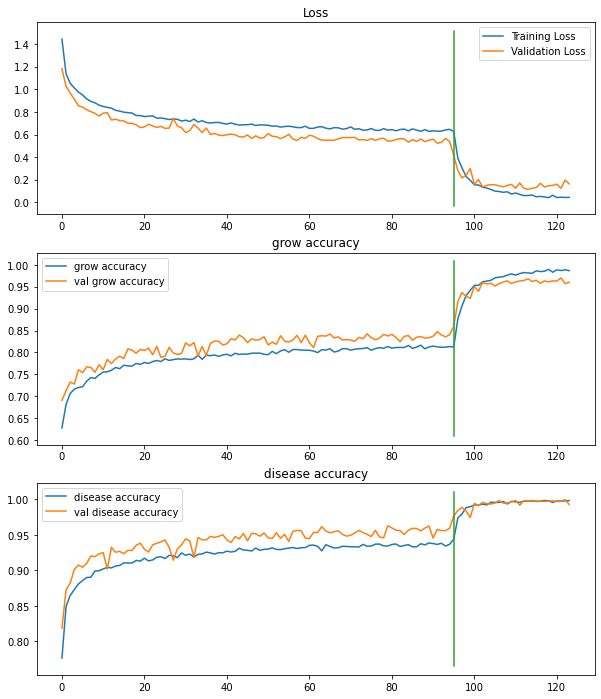

In [30]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(train_loss, label='Training Loss')
ax1.plot(valid_loss, label='Validation Loss')
ax1.legend(loc='best')
plt.plot([start,start],
          plt.ylim(), label='Start Fine Tuning')
ax1.set_title('Loss')

ax2 = fig.add_subplot(3,1,2)
ax2.plot(grow_acc, label='grow accuracy')
ax2.plot(val_grow_acc, label='val grow accuracy')
ax2.legend(loc='best')
plt.plot([start,start],
          plt.ylim(), label='Start Fine Tuning')
ax2.set_title('grow accuracy')

ax3 = fig.add_subplot(3,1,3)
ax3.plot(disease_acc, label='disease accuracy')
ax3.plot(val_disease_acc, label='val disease accuracy')
ax3.legend(loc='best')
plt.plot([start,start],
          plt.ylim(), label='Start Fine Tuning')
ax3.set_title('disease accuracy')

plt.savefig('./graph1.png')
plt.show()

In [31]:
model.save('./final_strawberry.h5')